# Introduction

## Symbol definitions
- $S_k$ SLM filter ($N \times 1$)
- $T$ Target image ($N \times 1$)
- $A$ Calibration Matrix ($N \times M$)
- $I_k$ Camera image ($M \times 1$)
- $G^2$ Reconstructed image ($N \times 1$)


## The equations for Multipixels Hadamard Imaging
$$
 I_k = A^T \times (T \odot S_k)
$$

$$
 G^{(2)} = \frac{1}{N/M} \sum_k (A \times I_k) \odot S_k
$$

# Environment Setup

## Collab integration

In [ ]:
# for colab integration
# if this is the first time you run the notebook, please run the following line
!git clone https://github.com/rstanuwijaya/pf32-python-analysis.git

# make sure you are in the correct directory
!echo
!echo Changed directory to:
%cd /content/pf32-python-analysis/demo/gdi_simulation

!echo
!echo List directory:
%ls

## Class Definition

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time

# from math import prod
import cv2

def prod(arr):
  res = 1
  for i in range(len(arr)):
    res *= arr[i]
  return res

# from ghost.multisim import GhostSimulator, GhostAnalyser

# plt.rcParams['text.usetex'] = True

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# from math import prod, sqrt, atan2, pi, ceil, log, log10, inf
from math import sqrt, atan2, pi, ceil, log, log10, inf
import random
import os
from PIL import Image
import cv2


class PathGenerator:
    def zigzag(shape, n):
        R = np.zeros(shape, dtype=bool)
        L = dict()
        for i in range(shape[0] * shape[1]):
            u, v = i // shape[1], i % shape[1]
            r, t = u + v, u
            L[(u, v)] = (r, t)
        L = {k: v for k, v in sorted(
            L.items(), key=lambda x: (x[1][0], x[1][1]))}
        for i, (u, v) in enumerate(L.keys()):
            if i < n:
                R[u, v] = True
        return R

    def circular(shape, n):
        R = np.zeros(shape, dtype=bool)
        L = dict()
        for i in range(shape[0] * shape[1]):
            u, v = i // shape[1], i % shape[1]
            r, t = sqrt(u**2 + v**2), atan2(u, v)
            L[(u, v)] = (r, t)
        L = {k: v for k, v in sorted(
            L.items(), key=lambda x: (x[1][0], x[1][1]))}
        for i, (u, v) in enumerate(L.keys()):
            if i < n:
                R[u, v] = True
        return R

    def square(shape, n):
        R = np.zeros(shape, dtype=bool)
        L = dict()
        for i in range(shape[0] * shape[1]):
            u, v = i // shape[1], i % shape[1]
            r = max(u, v)
            t = v if u < v else u + v
            L[(u, v)] = (r, t)
        L = {k: v for k, v in sorted(
            L.items(), key=lambda x: (x[1][0], x[1][1]))}
        for i, (u, v) in enumerate(L.keys()):
            if i < n:
                R[u, v] = True
        return R


class GhostSimulator:
    def __init__(self, path, shape_slm, shape_cam, shape_mac, num_filters, shift=(0, 0), sigma=0, method='zigzag'):
        self.path = path
        self.shape_slm = shape_slm  # SLM resolution
        self.shape_cam = shape_cam  # camera resolution
        self.shape_mac = shape_mac  # macro pixel shape
        self.sigma = sigma
        self.num_filters = num_filters
        self.shift = shift
        self.method = method
        self.T = None  # 2d target image
        self.h = self.generate_hadamard()  # 2d hadamard matrix
        self.A = None
        self.At = None
        self.R = None
        self.I = None
        self.G2 = None  # 2d reconstructed image

        self.reset_vars()

    def reset_vars(self):
        if self.sigma == 0:
            self.A, self.At = self.generate_cali_matrix_ideal()
        else:
            self.A, self.At = self.generate_cali_matrix_gaussian()
        self.R = np.zeros(self.shape_mac)
        self.I = np.empty((prod(self.shape_mac), prod(self.shape_cam)))
        self.I[:] = np.nan
        self.G2 = np.zeros(self.shape_slm)

    def generate_cali_matrix_ideal(self):
        A = np.zeros((prod(self.shape_slm), prod(self.shape_cam)))
        for i in range(prod(self.shape_slm)):
            u, v = i // self.shape_slm[1], i % self.shape_slm[1]
            slm = np.zeros(self.shape_slm)
            slm[u, v] = 1
            cam = cv2.resize(slm, self.shape_cam, interpolation=cv2.INTER_AREA)
            cam = cam * prod(self.shape_slm) / prod(self.shape_cam)
            A[i, :] = cam.flatten()

        S = A.T.sum(axis=1, keepdims=True)
        At = A.T/S
        return A, At

    def generate_cali_matrix_gaussian(self):
        cam_res = self.shape_cam
        slm_res = self.shape_slm
        mac_res = self.shape_mac
        sigma = self.sigma
        At = np.zeros((prod(cam_res), prod(slm_res)))
        for i in range(prod(cam_res)):
            u, v = i // cam_res[1], i % cam_res[1]
            x = np.arange(0, slm_res[0], 1)
            y = np.arange(0, slm_res[1], 1)
            xv, yv = np.meshgrid(x, y)
            xy = (xv - (u+0.5)*mac_res[0] + 0.5)**2 + \
                (yv - (v+0.5)*mac_res[1] + 0.5)**2
            temp = 1/(2*np.pi*sigma**2)*np.exp(-xy/(2*sigma**2))
            At[i] = temp.flatten()
        S = At.T.sum(axis=1, keepdims=True)
        A = At.T/S

        return A, At

    def generate_image_from_file(self, path):
        img = Image.open(path).resize(
            (self.shape_slm[1], self.shape_slm[0]), Image.ANTIALIAS).convert('L')
        img = np.asarray(img)
        return img

    def generate_hadamard(self):
        order = ceil(log(max(self.shape_mac[0], self.shape_mac[1]), 2))
        h = np.array([[1, 1], [1, -1]])
        for i in range(order-1):
            h = np.kron(h, np.array([[1, 1], [1, -1]]))

        # sort hadamard by frequency
        def calculate_flip(H):
            return sum([H[i] != H[i+1] for i in range(H.shape[0]-1)])

        h = np.array(sorted(h, key=lambda row: calculate_flip(row)))
        h = h[:self.shape_mac[0], :self.shape_mac[1]]

        return h

    def generate_partial_filter(self, i):
        # generate filter for one camera pixel
        u, v = i // self.shape_mac[1], i % self.shape_mac[1]
        h = self.generate_hadamard()
        S = h[:, [v]] @ h[[u], :]
        return S

    def generate_filter(self, i):
        # tiled filter
        Si = self.generate_partial_filter(i)
        shape = ceil(self.shape_slm[0] / self.shape_mac[0]
                     ), ceil(self.shape_slm[1] / self.shape_mac[1])
        Si = np.tile(Si, shape)
        Si = Si[:self.shape_slm[0], :self.shape_slm[1]]
        return Si

    def run_simulation(self):
        self.reset_vars()
        self.T = self.generate_image_from_file(self.path)  # 2d target image
        k = 0  # count of filters
        G2 = np.zeros(prod(self.shape_slm))
        if self.method == 'zigzag':
            self.R = PathGenerator.zigzag(self.shape_mac, self.num_filters)
        elif self.method == 'circular':
            self.R = PathGenerator.circular(self.shape_mac, self.num_filters)
        elif self.method == 'square':
            self.R = PathGenerator.square(self.shape_mac, self.num_filters)

        Tk = self.T.flatten()
        for i in range(self.shape_mac[0] * self.shape_mac[1]):
            u, v = i // self.shape_mac[1], i % self.shape_mac[1]
            if not self.R[u, v]:
                continue
            k += 1
            Sk = self.generate_filter(i)  # generate filter pattern
            Sk = np.roll(Sk, self.shift[0], axis=0)
            Sk = np.roll(Sk, self.shift[1], axis=1)
            Sk = Sk.flatten()

            # simulate measurement
            Ik = self.A.T @ (Tk*Sk)
            self.I[i, :] = Ik.T  # store to the intensity matrix

            # reconstruct image
            Sk = self.generate_filter(i).flatten()  # generate filter pattern
            G2 += (self.A @ Ik) * Sk

        G2 = G2 / prod(self.shape_mac)
        self.G2 = G2.reshape(self.shape_slm)
        return k

    def calc_rmse(self):
        return sqrt(np.sum((self.T - self.G2)**2) / (self.shape_slm[0] * self.shape_slm[1]))

    def calc_psnr(self):
        if self.calc_rmse() == 0:
            return inf
        return 20*log10(255/self.calc_rmse())


class GhostAnalyser(GhostSimulator):
    def __init__(self, path, shape_slm, shape_cam, shape_mac, crop, num_filters, shift=(0, 0), sigma=0, method='zigzag'):
        super().__init__(path, shape_slm, shape_cam,
                         shape_mac, num_filters, shift, sigma, method)
        self.crop = crop

    def run_simulation(self):
        raise NotImplementedError("Class not for simulation")

    def run_analysis(self):
        self.reset_vars()
        k = 0  # count of filters
        G2 = np.zeros(prod(self.shape_slm))
        if self.method == 'zigzag':
            self.R = PathGenerator.zigzag(self.shape_mac, self.num_filters)
        elif self.method == 'circular':
            self.R = PathGenerator.circular(self.shape_mac, self.num_filters)
        elif self.method == 'square':
            self.R = PathGenerator.square(self.shape_mac, self.num_filters)

        # Tk = self.T.flatten()
        for i in range(self.shape_mac[0] * self.shape_mac[1]):
            u, v = i // self.shape_mac[1], i % self.shape_mac[1]
            if not self.R[u, v]:
                continue
            k += 1

            # generate and shift the filter pattern
            Sk = self.generate_filter(i)
            Sk = np.roll(Sk, self.shift[0], axis=0)
            Sk = np.roll(Sk, self.shift[1], axis=1)
            Sk = Sk.flatten()

            # difference imaging and resizing
            Ik_p = np.loadtxt(self.path + f'{i}p.csv', delimiter=',')
            Ik_m = np.loadtxt(self.path + f'{i}m.csv', delimiter=',')
            Ik = Ik_p - Ik_m
            Ik = Ik[self.crop[0]:self.crop[1], self.crop[2]:self.crop[3]]
            Ik = cv2.resize(Ik, self.shape_cam, interpolation=cv2.INTER_AREA)
            Ik = Ik.flatten()

            # reconstruct image
            G2 += (self.A @ Ik) * Sk

        G2 = G2 / prod(self.shape_mac)
        self.G2 = G2.reshape(self.shape_slm)
        return k


# Simulation

## Single Simulation

Simulation using: SLM resolution (32, 32), camera resolution (8, 8)
Original image:


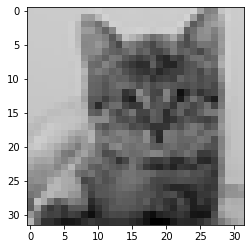

Reconstructed Image


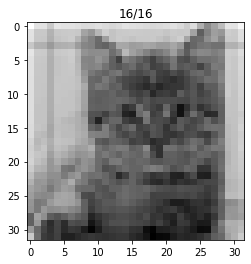

Active area of the camera


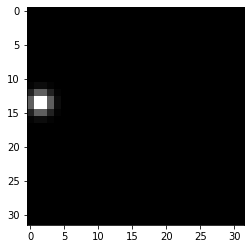

Hadamard matrix


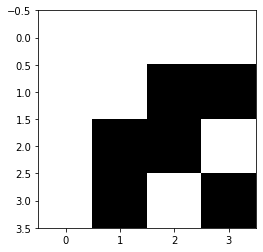

Last filter used


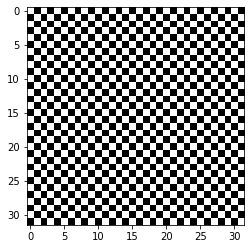

In [10]:
# image reconstruction simulation

# define simulation parameters
path = './data/cat.png'
slm_res = (32, 32)
cam_res = (8, 8)
mac_res = (4, 4)
shift = (0, 0)
n = 16
sigma = 0 # 0 for ideal calibration matrix

# create simulation and run it
print(f"Simulation using: SLM resolution {slm_res}, camera resolution {cam_res}")
sim = GhostSimulator(path, slm_res, cam_res, mac_res, n, shift=shift, sigma=sigma, method='zigzag')
cnt = sim.run_simulation()

# show original image
print("Original image:")
plt.imshow(sim.T, vmax=sim.G2.flatten().max(), cmap='gray')
plt.show()

# show reconstructed image
print("Reconstructed Image")
plt.title(f"{n}/{prod(mac_res)}")
plt.imshow(np.abs(sim.G2), vmax=sim.G2.flatten().max(), cmap='gray')
plt.show()

# show active area of the camera
print("Active area of the camera")
plt.imshow(sim.At.sum(axis=0).reshape(sim.shape_slm), cmap='gray')
plt.show()

# show hadamard matrix
print("Hadamard matrix")
plt.imshow(sim.h, vmin=-1, vmax=1, cmap='gray')
plt.show()

# show the last filter used
print("Last filter used")

plt.imshow(sim.generate_filter(cnt-1), cmap='gray')
plt.show()

## Gaussian Simulation

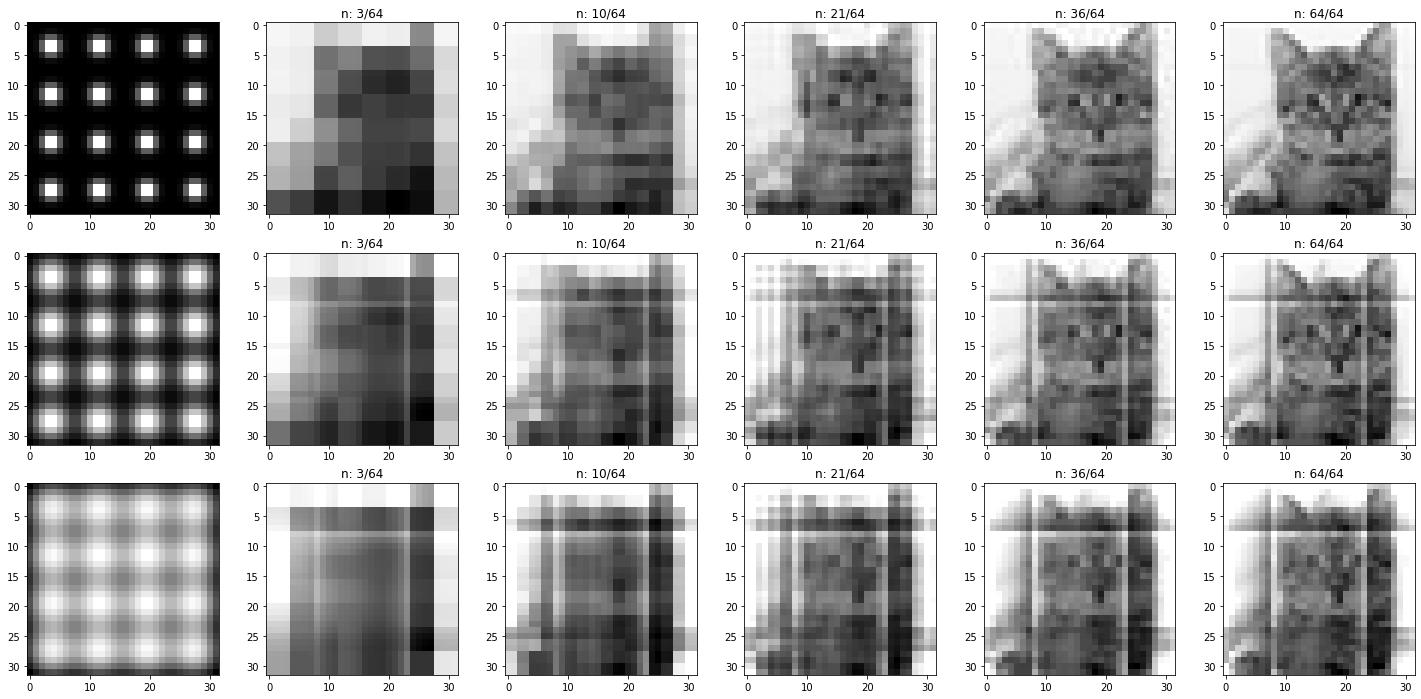

In [6]:
# gausssian simulation

path = './data/cat.png'
slm_res = (32, 32)
camera_res = (4, 4)
mac_res = (8, 8)
shift = (0, 0)
n_list = [3, 10, 21, 36, 64]
sigma_list =[1, 2, 3]

fig, axs = plt.subplots(len(sigma_list), len(n_list)+1, figsize=(25, 12))

for i, sigma in enumerate(sigma_list):
    sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, shift=shift, sigma=sigma, method='zigzag')
    axs[i, 0].imshow(sim.At.sum(axis=0).reshape(sim.shape_slm), cmap='gray')
    for j, n in enumerate(n_list):
        sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, shift=shift, sigma=sigma, method='zigzag')
        cnt = sim.run_simulation()
        axs[i, j+1].set_title(f"n: {n}/{prod(mac_res)}")
        axs[i, j+1].imshow(np.abs(sim.G2), vmax=sim.T.flatten().max(), cmap='gray')

plt.show()


## Shifted Image

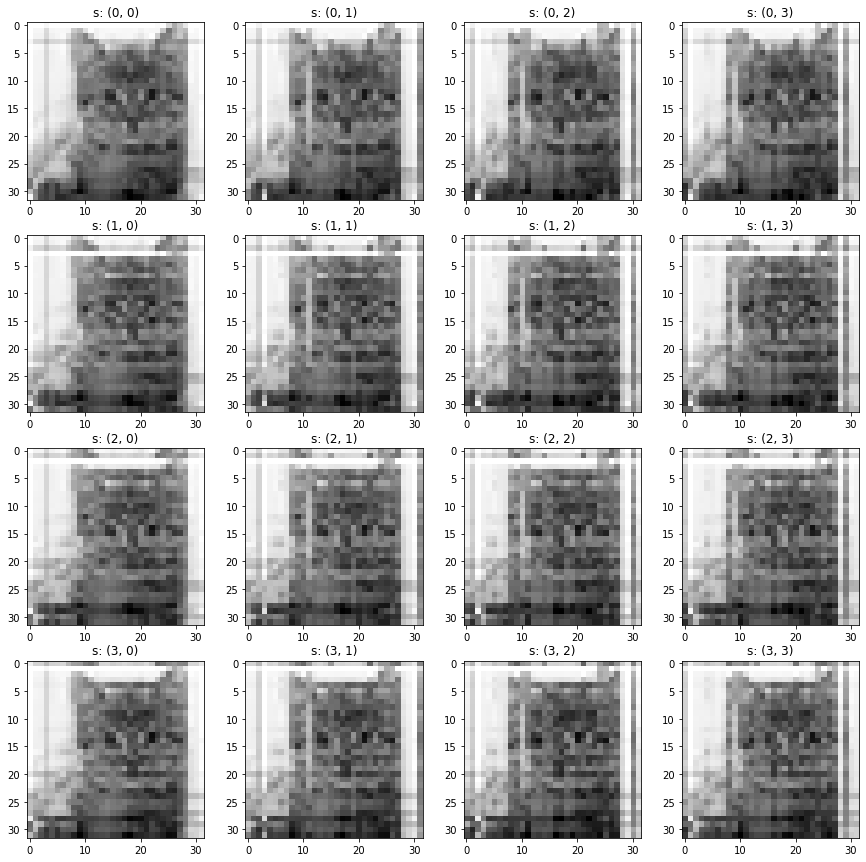

In [7]:
# shifted image simulation

path = './data/cat.png'
slm_res = (32, 32)
camera_res = (8, 8)
mac_res = (4, 4)
shift = (0, 0)
n = 16
sigma = 1

fig, axs = plt.subplots(4, 4, figsize=(15, 15))

avg = np.zeros(mac_res)
for i in range(4):
    for j in range(4):
        shift = (i, j)
        sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, shift=shift, sigma=sigma, method='zigzag')
        cnt = sim.run_simulation()
        avg[i, j] = np.average(sim.G2.flatten())
        ax = axs[i, j]
        axs[i, j].set_title(f"s: {shift}")
        axs[i, j].imshow(np.abs(sim.G2), vmax=sim.T.flatten().max(), cmap='gray')


# Analysis

## Preview Data

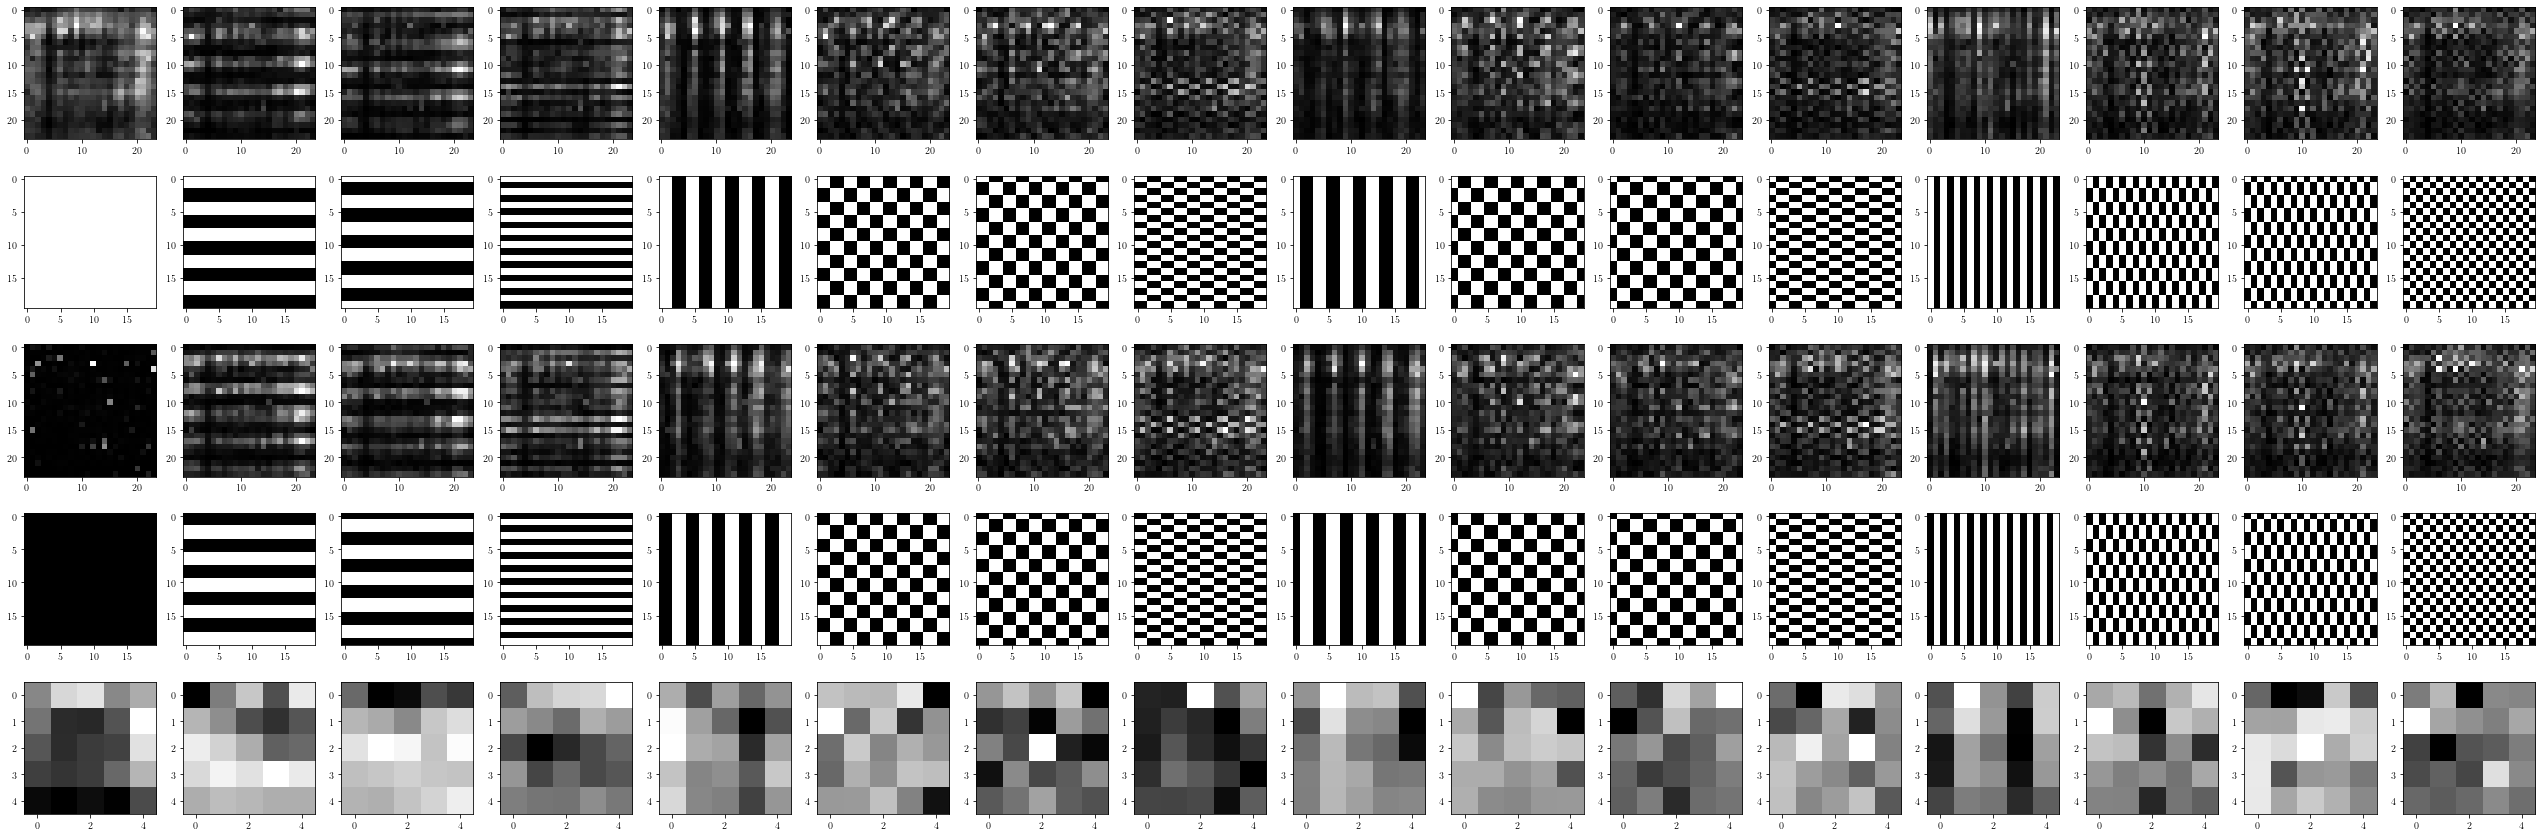

In [6]:
# experimental data analuysis
path = ("./data/220120_MultipixelImaging/")
crop = (0, 0+24, 4, 4+24)

slm_res = (20, 20)
cam_res = (5, 5)
mac_res = (4, 4)
shift = (0, 0)
n = 16
sigma = 0

sim = GhostAnalyser(path, slm_res, cam_res, mac_res, crop, 16, shift=shift, sigma=sigma)

fig, axs = plt.subplots(5, 16, figsize=(45, 15))

for i in range(16):
    Ik_p = np.loadtxt(path + f'{i}p.csv', delimiter=',')
    Ik_m = np.loadtxt(path + f'{i}m.csv', delimiter=',')
    Ik_p = Ik_p[crop[0]:crop[1], crop[2]:crop[3]]
    Ik_m = Ik_m[crop[0]:crop[1], crop[2]:crop[3]]
    Ik = Ik_p - Ik_m
    Ik = cv2.resize(Ik, cam_res, interpolation=cv2.INTER_AREA)

    axs[0, i].imshow(Ik_p, cmap='gray')    
    axs[1, i].imshow(sim.generate_filter(i) == 1, vmin=0, vmax=1, cmap='gray')
    axs[2, i].imshow(Ik_m, cmap='gray')
    axs[3, i].imshow(sim.generate_filter(i) == -1, vmin=0, vmax=1, cmap='gray')
    axs[4, i].imshow(Ik, cmap='gray')

plt.show()

## Image Reconstruction

Original image:


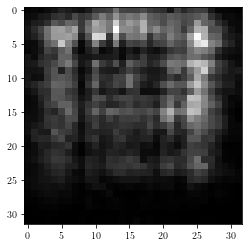

Cropped image:


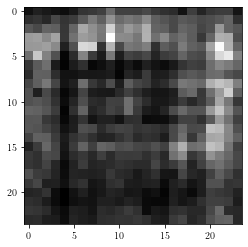

Resized image:


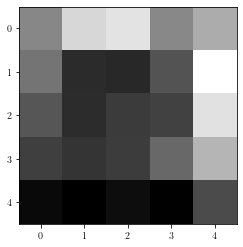

Reconstructed image:


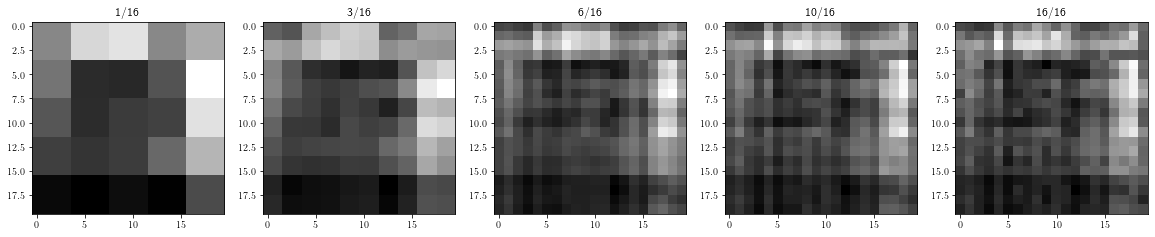

In [7]:
# image reconstruction simulation
path = ("./data/220120_MultipixelImaging/")
slm_res = (20, 20)
cam_res = (5, 5)
mac_res = (4, 4)
crop = (0, 0+24, 4, 4+24)
rot = (0, 0)
n = 16
sigma = 0

# show the original image after background subtraction
print("Original image:")
Ik_p = np.loadtxt(path + f'0p.csv', delimiter=',')
Ik_m = np.loadtxt(path + f'0m.csv', delimiter=',')
Ik = Ik_p - Ik_m
plt.imshow(Ik, cmap='gray')
plt.show()

# show cropped image
print("Cropped image:")
Ik = Ik[crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(Ik, cmap='gray')
plt.show()

# show the image after resizing
print("Resized image:")
Ik = cv2.resize(Ik, cam_res, interpolation=cv2.INTER_AREA)
plt.imshow(Ik, cmap='gray')
plt.show()

# reconstruct the image
print("Reconstructed image:")
n_list = (1, 3, 6, 10, 16)
fig, axs = plt.subplots(1, len(n_list), figsize=(20, 8))

for i, n in enumerate(n_list):
    sim = GhostAnalyser(path, slm_res, cam_res, mac_res, crop, n, shift=rot, sigma=sigma)
    cnt = sim.run_analysis()
    axs[i].set_title(f"{n}/{prod(mac_res)}")
    axs[i].imshow(np.abs(sim.G2), cmap='gray')
plt.show()    
